# [**Courbes d'√©talonnage de probabilit√©**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/1_16_calibration/plot_calibration_curve.ipynb)<br/>([_Probability Calibration curves_](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html))

Lors de la classification, on souhaite souvent pr√©dire non seulement l'√©tiquette de classe, mais √©galement la probabilit√© associ√©e. Cette probabilit√© donne une sorte de confiance dans la pr√©diction. Cet exemple montre comment visualiser la qualit√© de l'√©talonnage des probabilit√©s pr√©dites √† l'aide de courbes d'√©talonnage, √©galement appel√©es diagrammes de fiabilit√©. L'√©talonnage d'un classifieur non √©talonn√© sera √©galement d√©montr√©.

In [1]:
# Author: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD 3 clause.

# Jeu de donn√©es

Nous utiliserons un ensemble de donn√©es synth√©tique de classification binaire comprenant 100 000 √©chantillons et 20 caract√©ristiques. Parmi les 20 caract√©ristiques, seules 2 sont informatives, 10 sont redondantes (combinations al√©atoires des caract√©ristiques informatives) et les 8 restantes ne contiennent aucune information utile (nombres al√©atoires). Sur les 100 000 √©chantillons, 1 000 seront utilis√©s pour l'apprentissage du mod√®le et le reste pour les tests.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=10, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, random_state=42
)

# Courbes d'√©talonnage

## Naive Bayes Gaussien

Tout d'abord, nous allons comparer :
- [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (utilis√©e comme r√©f√©rence, car tr√®s souvent, la r√©gression logistique correctement r√©gularis√©e est bien √©talonn√©e par d√©faut gr√¢ce √† l'utilisation de la perte logarithmique)
- [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) non √©talonn√©e
- [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) avec √©talonnage isotone et sigmo√Øde (voir [**Guide de l'utilisateur** (1.16)](https://scikit-learn.org/stable/modules/calibration.html#calibration))

Les courbes d'√©talonnage pour ces 4 conditions sont repr√©sent√©es ci-dessous, avec la probabilit√© pr√©dite moyenne pour chaque bin sur l'axe des x et la fraction de classes positives dans chaque bin sur l'axe des y.

In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]

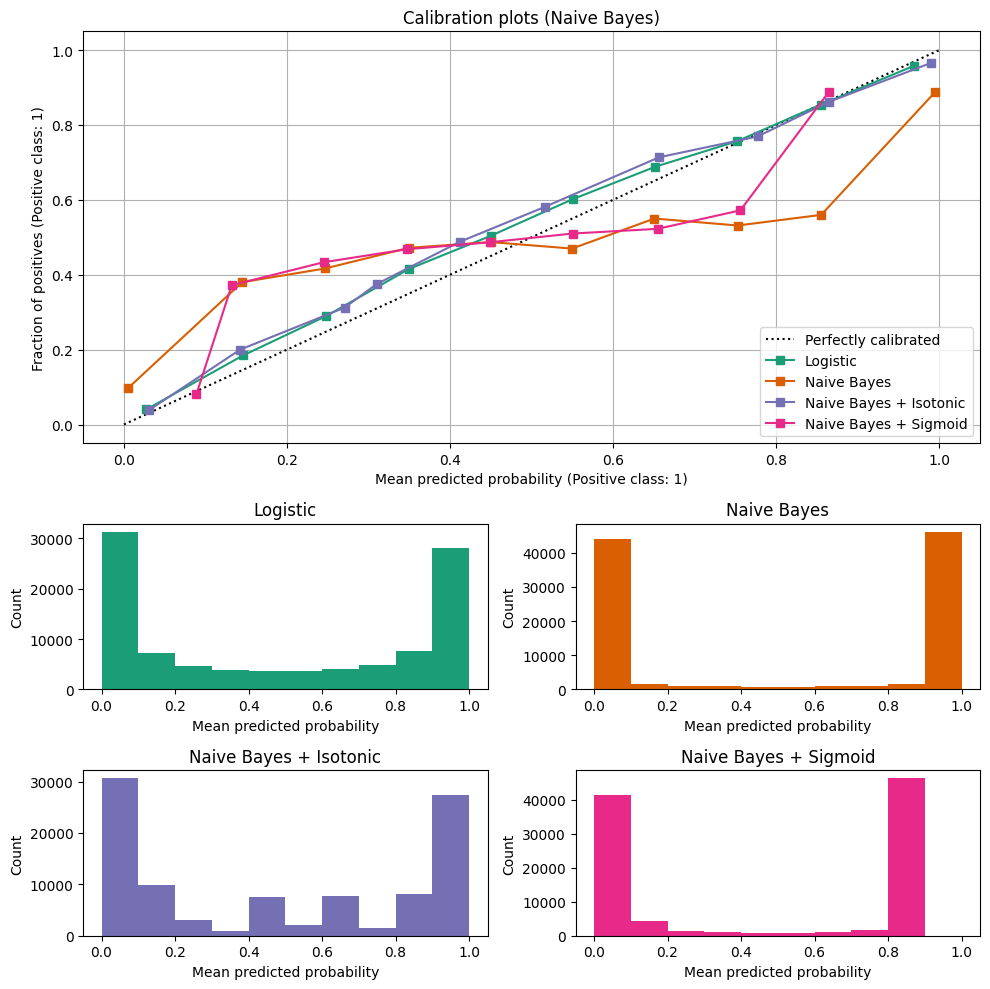

In [4]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

Le [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) non √©talonn√© est mal √©talonn√© en raison des caract√©ristiques redondantes qui contreviennent √† l'hypoth√®se d'ind√©pendance des caract√©ristiques et qui donnent lieu √† un classifieur excessivement confiant, comme l'indique la courbe caract√©ristique typique de la sigmo√Øde transpos√©e. L'√©talonnage des probabilit√©s de [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive-bayes.GaussianNB) avec la [**r√©gression isotone** (1.15)](https://scikit-learn.org/stable/modules/isotonic.html#isotonic) peut r√©soudre ce probl√®me, comme le montre la courbe d'√©talonnage presque diagonale. La [**r√©gression sigmo√Øde** (1.16.3.1)](https://scikit-learn.org/stable/modules/calibration.html#sigmoid-regressor) am√©liore √©galement l√©g√®rement l'√©talonnage, bien que pas aussi nettement que la r√©gression non param√©trique isotone. Cela peut s'expliquer par le fait que nous disposons de nombreuses donn√©es d'√©talonnage, de sorte que la plus grande flexibilit√© du mod√®le non param√©trique peut √™tre exploit√©e.

Nous allons maintenant effectuer une analyse quantitative en tenant compte de plusieurs mesures de classification : [**perte de score Brier** (3.3.2.18)](https://scikit-learn.org/stable/modules/model_evaluation.html#brier-score-loss), [**perte logarithmique** (3.3.2.12)](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss), [**pr√©cision, rappel, score F1** (3.3.2.9)](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics) et [**AUC ROC** (3.3.2.15)](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).

In [5]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

Brier  loss  Log loss  Roc auc   Precision    Recall   \
Classifier                                                                      
Logistic                   0.098921  0.323178  0.937457    0.872009  0.851408   
Naive Bayes                0.117608  0.782755  0.940374    0.857400  0.875941   
Naive Bayes + Isotonic     0.098332  0.370738  0.938613    0.883065  0.836224   
Naive Bayes + Sigmoid      0.108880  0.368896  0.940201    0.861106  0.871277   

                             F1   
Classifier                        
Logistic                0.861586  
Naive Bayes             0.866571  
Naive Bayes + Isotonic  0.859007  
Naive Bayes + Sigmoid   0.866161

Remarquez que bien que l'√©talonnage am√©liore la [**perte de score Brier** (3.3.2.18)](https://scikit-learn.org/stable/modules/model_evaluation.html#brier-score-loss) (une m√©trique compos√©e d'un terme d'√©talonnage et d'un terme de raffinement) et la [**perte logarithmique** (3.3.2.12)](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss), il n'alt√®re pas significativement les mesures de pr√©cision, de rappel et de score F1 de la pr√©diction. Cela est d√ª au fait que l'√©talonnage ne devrait pas modifier de mani√®re significative les probabilit√©s de pr√©diction au niveau du seuil de d√©cision (√† x = 0,5 sur le graphique). L'√©talonnage devrait cependant rendre les probabilit√©s pr√©dites plus pr√©cises et donc plus utiles pour prendre des d√©cisions d'allocation en cas d'incertitude. De plus, l'AUC ROC ne devrait pas du tout changer car l'√©talonnage est une transformation monotone. En effet, aucune m√©trique de classement n'est affect√©e par l'√©talonnage.

### Classifieur √† vecteurs de support lin√©aires

Ensuite, nous allons comparer :
- [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (baseline)
- [**`LinearSVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) non √©talonn√©. √âtant donn√© que SVC ne produit pas de probabilit√©s par d√©faut, nous mettons na√Øvement √† l'√©chelle la sortie de la [**`decision_function`**](https://scikit-learn.org/stable/glossary.html#term-decision_function) dans l'intervalle $[0, 1]$ en appliquant une mise √† l'√©chelle min-max.
- [**`LinearSVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) avec √©talonnage isotone et sigmo√Øde (voir [**Guide de l'utilisateur** (1.16)](https://scikit-learn.org/stable/modules/calibration.html#calibration)).

In [6]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output for binary classification."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0, 1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        return np.c_[proba_neg_class, proba_pos_class]

In [7]:
lr = LogisticRegression(C=1.0)
svc = NaivelyCalibratedLinearSVC(max_iter=10_000, dual="auto")
svc_isotonic = CalibratedClassifierCV(svc, cv=2, method="isotonic")
svc_sigmoid = CalibratedClassifierCV(svc, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (svc, "SVC"),
    (svc_isotonic, "SVC + Isotonic"),
    (svc_sigmoid, "SVC + Sigmoid"),
]

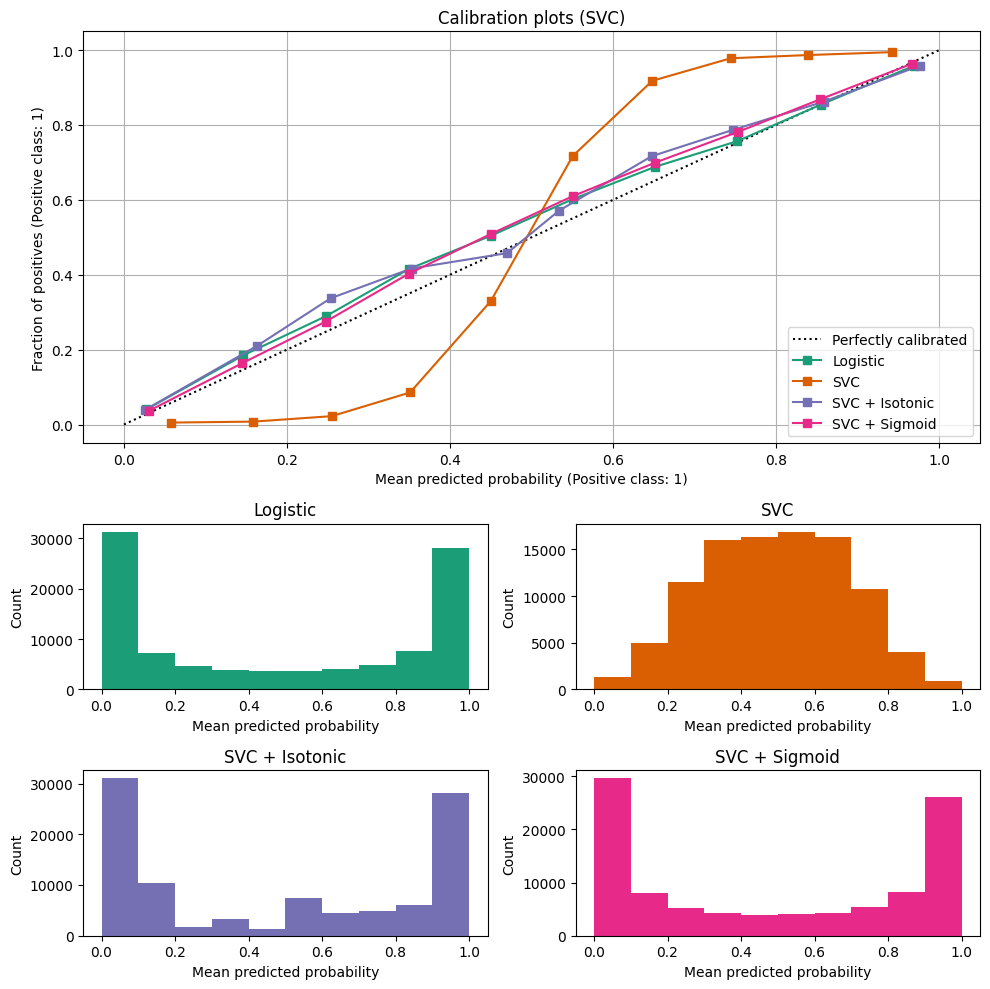

In [8]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (SVC)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

[**`LinearSVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) pr√©sente un comportement oppos√© √† celui de [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) ; la courbe d'√©talonnage a une forme sigmo√Øde, ce qui est typique d'un classifieur peu confiant. Dans le cas de [**`LinearSVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC), cela est d√ª √† la propri√©t√© de marge de la perte de charni√®re, qui se concentre sur les √©chantillons proches de la fronti√®re de d√©cision (vecteurs de support). Les √©chantillons √©loign√©s de la fronti√®re de d√©cision n'ont pas d'impact sur la perte de charni√®re. Il est donc logique que [**`LinearSVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) ne tente pas de s√©parer les √©chantillons dans les r√©gions de haute confiance. Cela se traduit par des courbes d'√©talonnage plus plates pr√®s de 0 et 1, comme le montrent des observations empiriques avec divers ensembles de donn√©es dans Niculescu-Mizil & Caruana [1].

Les deux types d'√©talonnage (sigmo√Øde et isotone) peuvent r√©soudre ce probl√®me et donner des r√©sultats similaires.

Comme pr√©c√©demment, nous pr√©sentons le [**Brier score loss** (3.3.2.18)](https://scikit-learn.org/stable/modules/model_evaluation.html#brier-score-loss), la [**log loss** (3.3.2.12)](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss), la [**pr√©cision, le rappel, le score F1** (3.3.2.9)](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics) et l'[**aire sous la courbe ROC (AUC ROC)** (3.3.2.15)](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).

In [9]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

Brier  loss  Log loss  Roc auc   Precision    Recall   \
Classifier                                                              
Logistic           0.098921  0.323178  0.937457    0.872009  0.851408   
SVC                0.144943  0.465660  0.937597    0.872186  0.851792   
SVC + Isotonic     0.099820  0.376999  0.936480    0.853174  0.877981   
SVC + Sigmoid      0.098758  0.321301  0.937532    0.873724  0.848743   

                     F1   
Classifier                
Logistic        0.861586  
SVC             0.861868  
SVC + Isotonic  0.865400  
SVC + Sigmoid   0.861053

Tout comme pour [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) ci-dessus, l'√©talonnage am√©liore √† la fois le [**Brier score loss** (3.3.2.18)](https://scikit-learn.org/stable/modules/model_evaluation.html#brier-score-loss) et la [**log loss** (3.3.2.12)](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss), mais n'alt√®re pas beaucoup les mesures de pr√©cision des pr√©dictions ([**pr√©cision, rappel, score F1** (3.3.2.9)](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)).

# R√©sum√©

L'√©talonnage sigmo√Øde param√©trique peut traiter les situations o√π la courbe d'√©talonnage du classifieur de base est sigmo√Øde (par exemple, pour [**`LinearSVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)), mais pas lorsqu'elle est transpos√©e-sigmo√Øde (par exemple, [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive-bayes.GaussianNB)). L'√©talonnage isotone non param√©trique peut g√©rer les deux situations, mais peut n√©cessiter davantage de donn√©es pour produire de bons r√©sultats.

# References

üî¨ [1] [**‚ÄúPredicting Good Probabilities With Supervised Learning‚Äù**](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.60.7135&rep=rep1&type=pdf), A. Niculescu-Mizil & R. Caruana, ICML 2005